In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon

ox.__version__

'1.3.0'

In [18]:
# configure the place, network type, trip times, and travel speed
place = {"city": "Berkeley", "state": "California"}
network_type = "walk"
trip_times = [5, 10, 15, 20, 25]  # in minutes
travel_speed = 4.5  # walking speed in km/hour

In [19]:
# download the street network
G = ox.graph_from_place(place, network_type=network_type)

In [20]:
# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes["geometry"].unary_union.centroid.xy
center_node = ox.distance.nearest_nodes(G, x[0], y[0])
G = ox.project_graph(G)

In [21]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [22]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0)

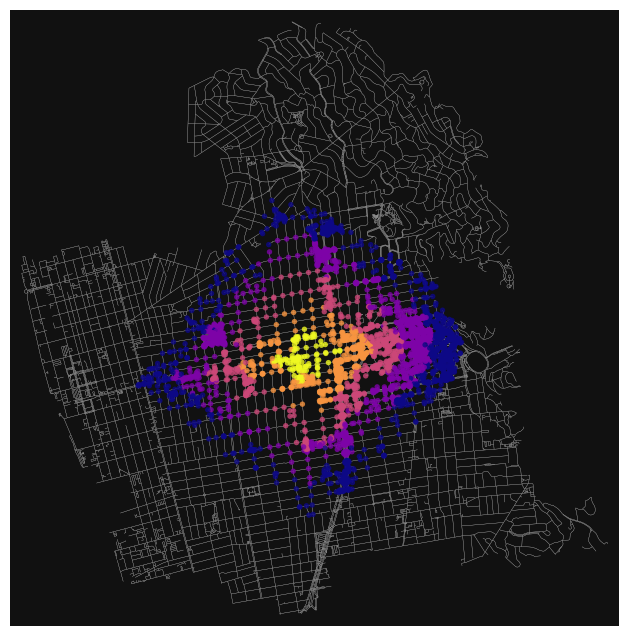

In [23]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)

In [24]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)
gdf = gpd.GeoDataFrame(geometry=isochrone_polys)

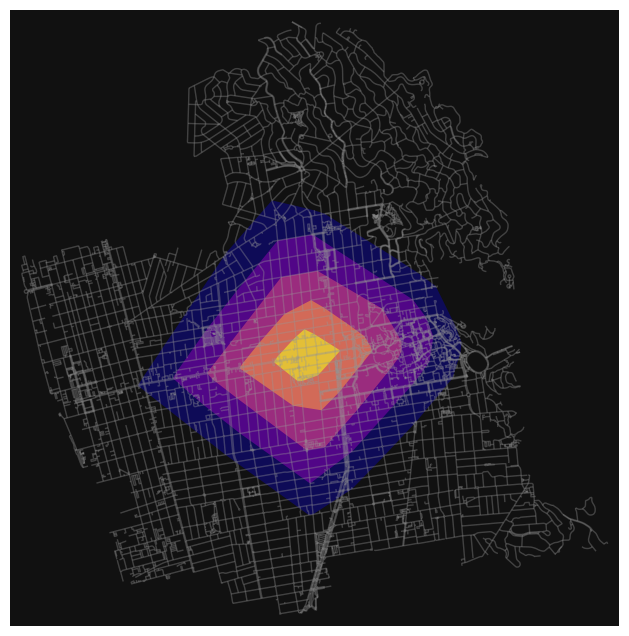

In [25]:
# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)
plt.show()

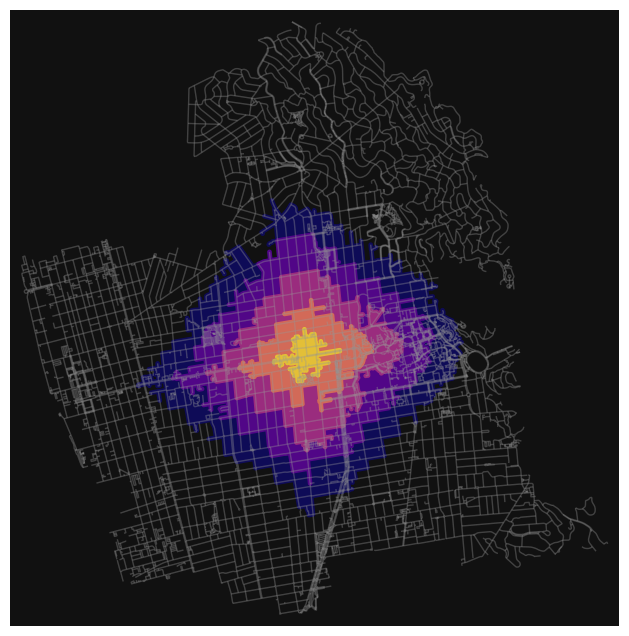

In [26]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")

        node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        # try to fill in surrounded areas so shapes will appear solid and
        # blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys


# make the isochrone polygons
isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
gdf = gpd.GeoDataFrame(geometry=isochrone_polys)

# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)
plt.show()